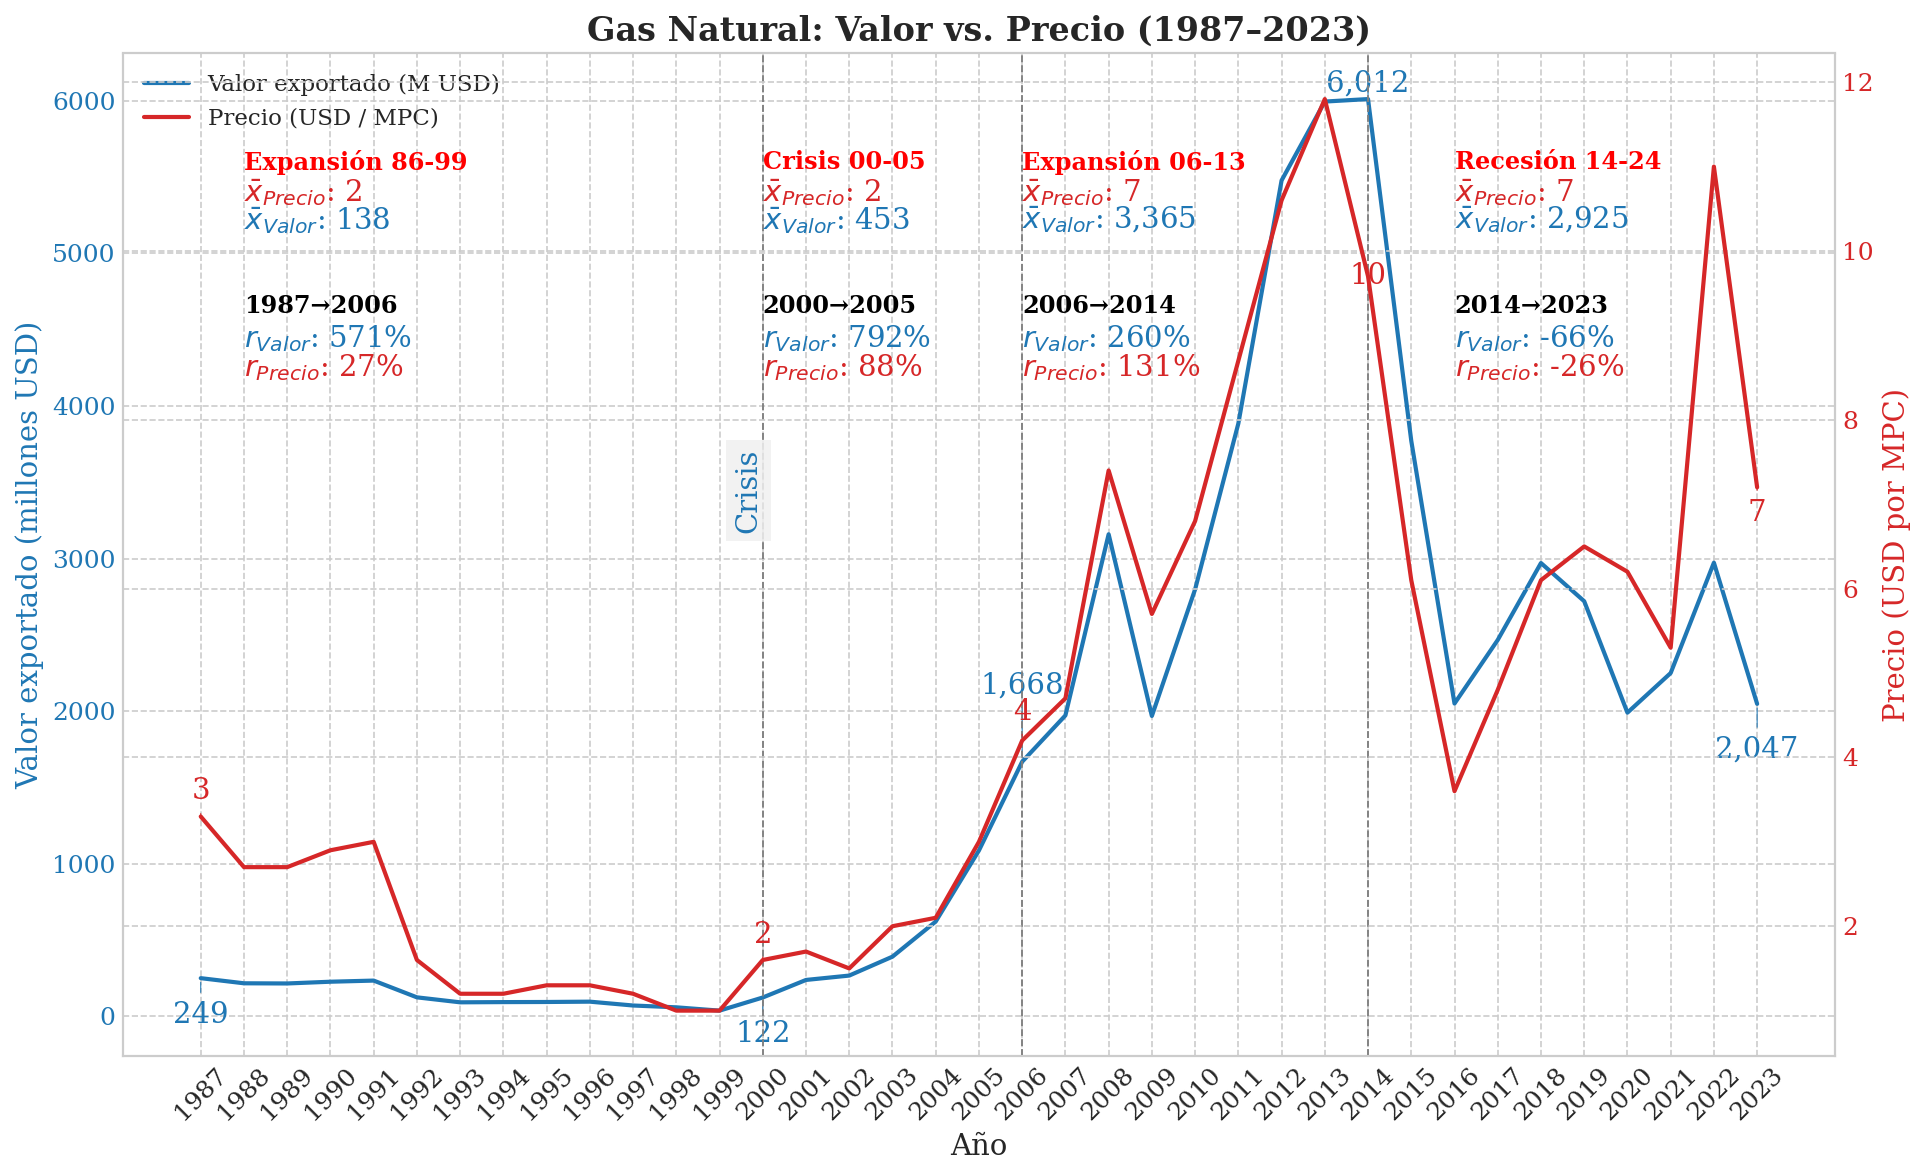

In [4]:
"""
Gas natural: Valor exportado vs. precio (1987-2023)
Versión que usa *exclusivamente* los helpers de graficos_utils
y oculta las entradas «_child…» de la leyenda.
"""

# ── 0. Imports ───────────────────────────────────────────────────────
import sys, os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# helpers propios
sys.path.append(os.path.abspath('../'))
from graficos_utils import (
    add_hitos,
    add_cycle_means_multi,
    add_year_value_annotations,
    add_period_growth_annotations_multi,
    add_participation_cycle_boxes,   # (no se usa aquí, pero disponible)
)

# ── 1. Configuración general ─────────────────────────────────────────
OUTPUT_DIR = "../../../../assets/tesis/serie_completa/exportaciones"
os.makedirs(OUTPUT_DIR, exist_ok=True)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif", "font.size": 12,
    "axes.titlesize": 16,   "axes.labelsize": 14,
    "grid.linestyle": "--", "lines.linewidth": 2,
    "figure.dpi": 150,      "savefig.bbox": "tight",
})

# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = (pd.read_sql("SELECT año,valor,precio_usd_mpc FROM exportacion_gas_natural", conn,
                      index_col="año")
            .sort_index())              # 1987-2024

df["valor_musd"] = df["valor"] / 1_000     # miles USD → millones
df.drop(columns="valor", inplace=True)
# ── 3. Ciclos y estadísticas ─────────────────────────────────────────
periods = {
    "Expansión 86-99": slice(1986, 1999),
    "Crisis 00-05":    slice(2000, 2005),
    "Expansión 06-13": slice(2006, 2013),
    "Recesión 14-24":  slice(2014, 2024),
}
cycle_stats = {name: df.loc[s].mean().to_dict() for name, s in periods.items()}

# ── 4. Series, colores y abreviaturas ────────────────────────────────
cols   = ["valor_musd", "precio_usd_MPC"]
abbr   = {"valor_musd": "Valor", "precio_usd_MPC": "Precio"}
colors = {"valor_musd": "#1f77b4", "precio_usd_MPC": "#d62728"}

# ── 5. Hitos y offsets ───────────────────────────────────────────────
hitos_v = {
    2000: "Crisis",
    2006: "Expansión",
    2014: "Recesión"
}
hitos_offset = {2000: .59, 2006: .62, 2014: .48}

anot_years = [1987, 2000, 2006, 2014, 2023]
annotation_offsets = {
    "valor_musd": {
        1987: (0, -240),
        2000: (0, -240),
        2006: (0, 500),
        2013: (0, 100),
        2014: (0, 100),
        2023: (0, -300),
    },
    "precio_usd_MPC": {
        1987: (0, 0.3),
        2000: (0, 0.3),
        2006: (0, 0.34),
        2013: (0, -2),
        2014: (0, 0),
        2023: (0, -0.3),
    },
}

growth_periods = [(1987,2006), (2000,2005), (2006,2014), (2014,2023)]
period_growth_offsets = {
    "1987-2006": (1988, 0.75),
    "2000-2005": (2000, 0.75),
    "2006-2014": (2006, 0.75),
    "2014-2023": (2016, 0.75),
}


# ── 6. Gráfico ───────────────────────────────────────────────────────
fig, ax_val = plt.subplots(figsize=(13,8))
ax_price    = ax_val.twinx()

ax_val.plot(df.index, df["valor_musd"],     label="Valor exportado (M USD)",
              color=colors["valor_musd"])
ax_price.plot(df.index, df["precio_usd_MPC"], label="Precio (USD / MPC)",
              color=colors["precio_usd_MPC"])

# ── 7. Helpers de graficos_utils ─────────────────────────────────────
add_hitos(ax_val, df.index, hitos_v, hitos_offset, line_kwargs={"linewidth":0.9})

medias_offset = {
    "Expansión 86-99": (1988, .90),
    "Crisis 00-05": (2000, .90),
    "Expansión 06-13": (2006, .90),
    "Recesión 14-24":  (2016, .90),
}
y_max = df["valor_musd"].max()
add_cycle_means_multi(ax_val, cycle_stats, medias_offset,
                      abbr, colors, line_spacing=y_max*0.03)

# ── 7.3 Valores puntuales ────────────────────────────────────────────
# • Anotamos sólo 'valor_musd' en ax_val
add_year_value_annotations(
    ax_val, df, anot_years,
    ["valor_musd"],          # sólo valor
    {"valor_musd": annotation_offsets["valor_musd"]},
    {"valor_musd": colors["valor_musd"]},
    arrow_lw=0.5
)

# • Anotamos sólo 'precio_usd_MPC' en ax_price
add_year_value_annotations(
    ax_price, df, anot_years,
    ["precio_usd_MPC"],      # sólo precio
    {"precio_usd_MPC": annotation_offsets["precio_usd_MPC"]},
    {"precio_usd_MPC": colors["precio_usd_MPC"]},
    arrow_lw=0.5
)


add_period_growth_annotations_multi(
    ax_val, df, growth_periods,
    cols, period_growth_offsets,
    colors, abbr
)

# ── 8. Etiquetas y leyenda limpia ────────────────────────────────────
ax_val.set_title(f"Gas Natural: Valor vs. Precio ({df.index[0]}–{df.index[-1]})",
                 fontweight="bold")
ax_val.set_xlabel("Año")
ax_val.set_ylabel("Valor exportado (millones USD)", color=colors["valor_musd"])
ax_price.set_ylabel("Precio (USD por MPC)",          color=colors["precio_usd_MPC"])

ax_val.tick_params(axis="y", labelcolor=colors["valor_musd"])
ax_price.tick_params(axis="y", labelcolor=colors["precio_usd_MPC"])
ax_val.set_xticks(df.index[::max(1,len(df)//31)])
ax_val.tick_params(axis="x", rotation=45)

# ----- leyenda filtrada (sin _childX) -------------------------------
handles, labels = ax_val.get_legend_handles_labels()
handles2, labels2 = ax_price.get_legend_handles_labels()
handles += handles2
labels  += labels2
filtered = [(h,l) for h,l in zip(handles,labels) if not l.startswith('_')]
if filtered:
    h_f, l_f = zip(*filtered)
    ax_val.legend(h_f, l_f, loc="upper left", fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,"gas_natural_valor_precio_dual_axis.png"),
            dpi=300)
plt.show()

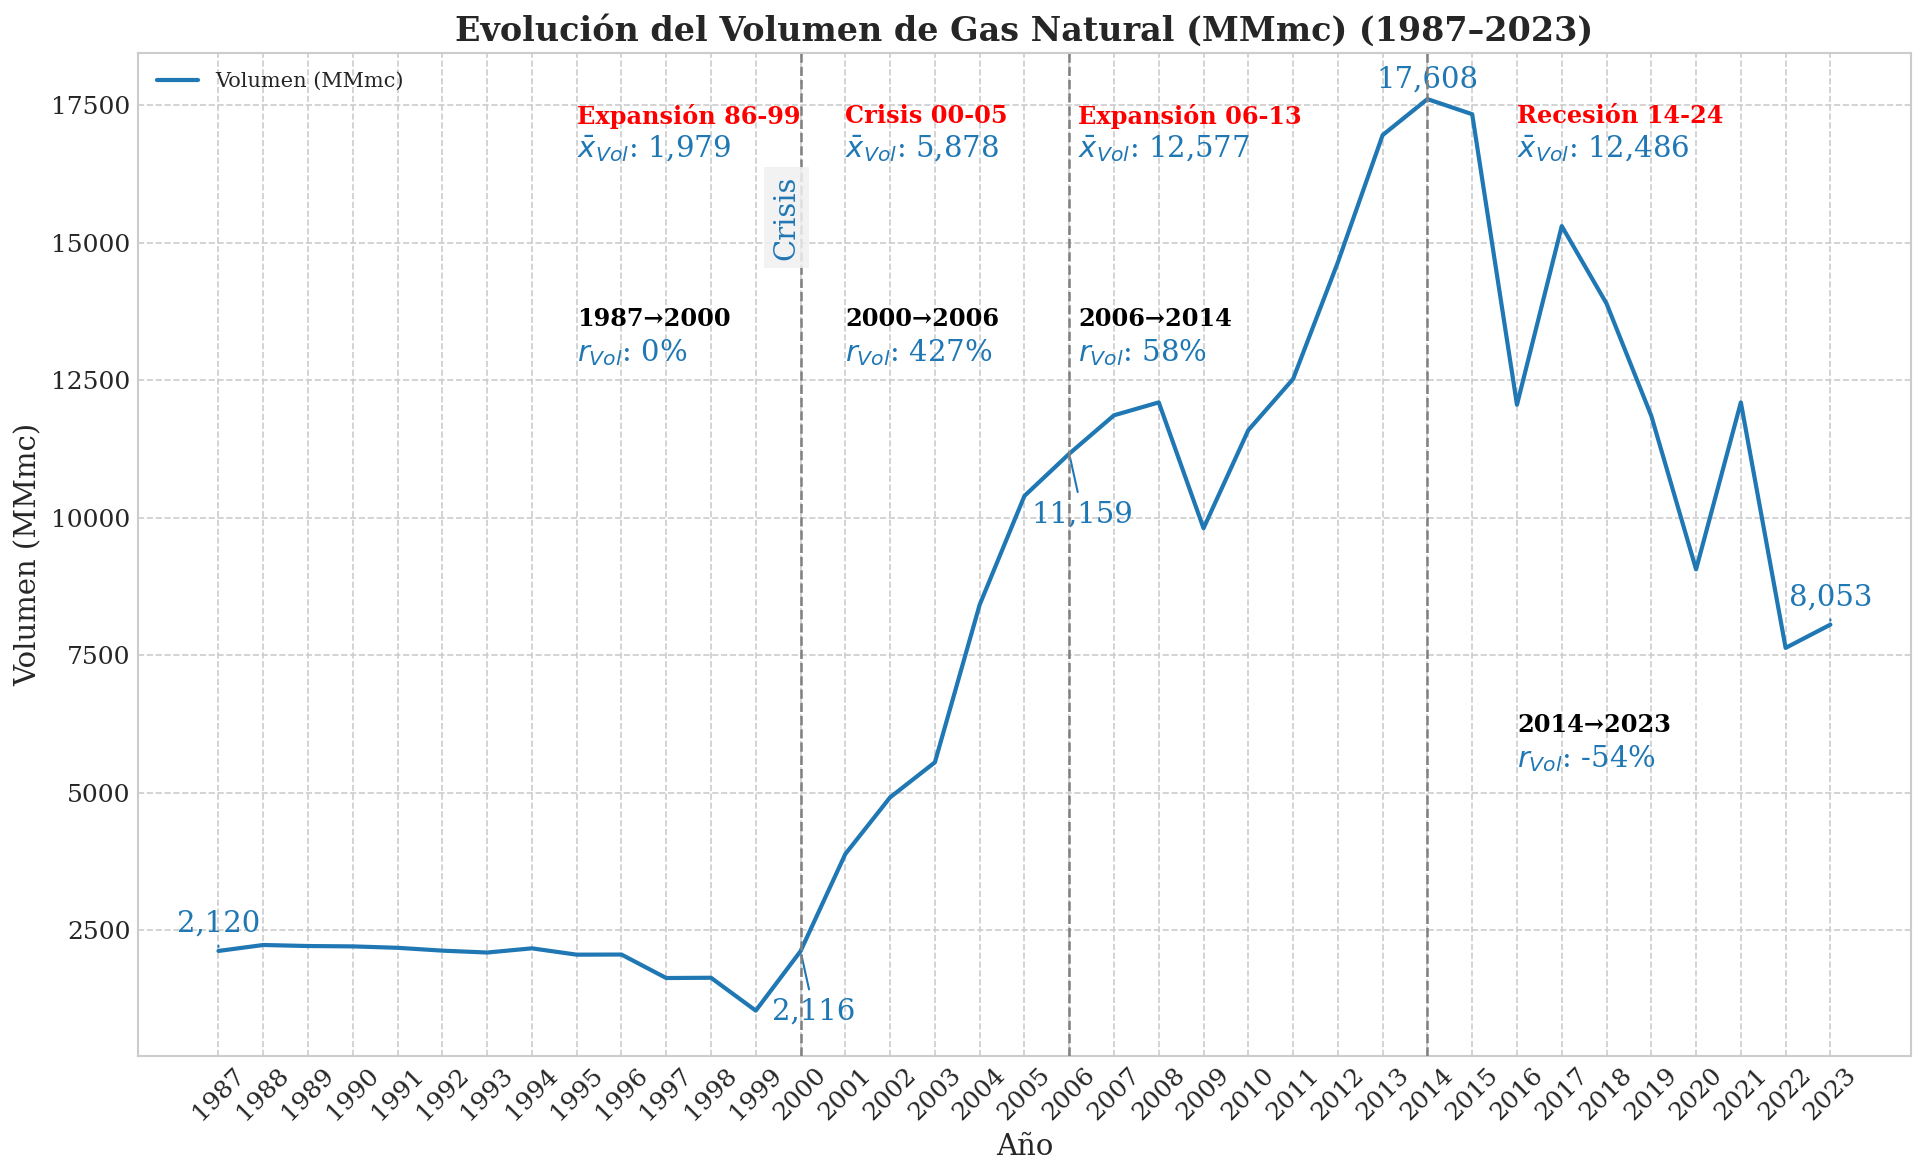

In [5]:
# ── 1. Nueva carga de datos (solo volumen) ───────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df_vol = (
        pd.read_sql(
            "SELECT año, volumen_MMMc FROM exportacion_gas_natural",
            conn,
            index_col="año"
        )
        .sort_index()
    )

# ── 2. Definición de ciclos y estadísticas ───────────────────────────
period_slices = {
    "Expansión 86-99": slice(1986, 1999),
    "Crisis 00-05":    slice(2000, 2005),
    "Expansión 06-13": slice(2006, 2013),
    "Recesión 14-24":  slice(2014, 2024),
}
cycle_stats_vol = {
    name: df_vol.loc[slice_].mean().to_dict()
    for name, slice_ in period_slices.items()
}

# ── 3. Hitos, años clave y offsets ────────────────────────────────────
hitos_offset = {yr: 0.88 for yr in hitos_v}   # texto al 88% del eje y

anot_years = [1987, 2000, 2006, 2014, 2023]
annotation_offsets_vol = {
    "volumen_MMMc": {
        1987: (0, 500),
        2000: (0.3, -1100),
        2006: (0.3, -1100),
        2014: (0, 350),
        2023: (0, 500),
    }
}

# ── 4. Periodos de crecimiento y offsets ─────────────────────────────
growth_periods = [(1987, 2000), (2000, 2006), (2006, 2014), (2014, 2023)]
period_growth_offsets = {
    "1987-2000": (1995, 0.75),
    "2000-2006": (2001, 0.75),
    "2006-2014": (2006.2, 0.75),
    "2014-2023": (2016, 0.35),
}

# ── 5. Offset para medias de ciclo ───────────────────────────────────
cycle_text_offsets = {
    "Expansión 86-99": (1995, 0.95),
    "Crisis 00-05":    (2001, 0.95),
    "Expansión 06-13": (2006.2, 0.95),
    "Recesión 14-24":  (2016, 0.95),
}

# ── 6. Paleta y abreviatura ──────────────────────────────────────────
colors_vol = {"volumen_MMMc": "tab:blue"}
abbr_vol   = {"volumen_MMMc": "Vol"}

# ── 7. Gráfico de volumen ────────────────────────────────────────────
fig_v, ax_v = plt.subplots(figsize=(13, 8))

# Serie
ax_v.plot(
    df_vol.index,
    df_vol["volumen_MMMc"],
    label="Volumen (MMmc)",
    color=colors_vol["volumen_MMMc"]
)

# Hitos
add_hitos(
    ax_v,
    df_vol.index,
    hitos_v,
    hitos_offset,
    line_kwargs={"lw": 1.2}
)

# Medias de ciclo
add_cycle_means_multi(
    ax_v,
    cycle_stats_vol,
    cycle_text_offsets,
    abbr_vol,
    colors_vol,
    line_spacing=df_vol["volumen_MMMc"].max() * 0.03
)

# Anotaciones de valores puntuales
add_year_value_annotations(
    ax_v,
    df_vol,
    anot_years,
    ["volumen_MMMc"],
    annotation_offsets_vol,
    colors_vol,
    arrow_lw=1.0
)

# Tasas de crecimiento
add_period_growth_annotations_multi(
    ax_v,
    df_vol,
    growth_periods,
    ["volumen_MMMc"],
    period_growth_offsets,
    colors_vol,
    abbr_vol
)

# ── 8. Ajustes finales ───────────────────────────────────────────────
ax_v.set_title(
    f"Evolución del Volumen de Gas Natural (MMmc) "
    f"({df_vol.index[0]}–{df_vol.index[-1]})",
    fontweight="bold"
)
ax_v.set_xlabel("Año")
ax_v.set_ylabel("Volumen (MMmc)")
ax_v.set_xticks(df_vol.index[::max(1, len(df_vol)//31)])
ax_v.tick_params(axis="x", rotation=45)
ax_v.legend(loc="upper left", fontsize=10)

plt.tight_layout()
plt.savefig(
    os.path.join(OUTPUT_DIR, "gas_natural_volumen_MMMc.png"),
    dpi=300
)
plt.show()

In [6]:
df

,precio_usd_MPC,valor_musd
año,,
1987,3.3,248.5790
1988,2.7,214.9480
1989,2.7,213.7865
1990,2.9,225.2710
1991,3.0,232.6630
1992,1.6,122.8128
1993,1.2,90.2029
1994,1.2,91.6037
1995,1.3,92.4073
